# Post-process

While `eodag` 's main goal is to offer an easy way to search and download EO products, it doesn't want to be a dead-end to the users who would like to post-process the products they have downloaded.

## Products file path

The download methods all return the local path of each product downloaded. Theses paths can be fed into another program for further processing. See for instance the tutorial that makes use of [SNAP](https://step.esa.int/main/toolboxes/snap/) to detect ships on *Sentinel 1* images.

<div class="alert alert-warning">

Note

The file paths returned (strings) are in the file URI format (e.g. `file:///tmp` on Linux). You may need in some occasions to remove the `file://` prefix.

</div>

## Sentinel: SAFE Format

Sentinel products are generally distributed in the [SAFE format](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats). AWS-based providers however offers Sentinel products in a "scattered" way, each file being able to be downloaded individually. `eodag` downloads these multiple files and automatically builds a SAFE product out of them. Image processing softwares such as [SNAP](https://step.esa.int/main/toolboxes/snap/) work well with products in the SAFE format.

## Data access with [eodag-cube](https://github.com/CS-SI/eodag-cube)

At some point `eodag` had some capabilities to directly post-process a product, i.e. to access its data. These capabilities, which relied on [rasterio](https://rasterio.readthedocs.io/en/latest/), have been ported to the Python package [eodag-cube](https://github.com/CS-SI/eodag-cube) to avoid the heavy dependencies associated with *rasterio* and *GDAL* in particular. Installing this package is enough to benefit from its capabilities.

[eodag-cube](https://github.com/CS-SI/eodag-cube) is going to extend the [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) class with a `get_data()` method which returns a product's image band as a `xarray.DataArray`. If the product has not yet been downloaded, `get_data()` will take care of downloading it first and will then return the required band data.

### Setup

A search is made to get *Sentinel 2 Level-1C* products from *PEPS*.

<div class="alert alert-warning">

Warning

[eodag-cube](https://github.com/CS-SI/eodag-cube) needs to be installed to run correcly the following code.

</div>

In [1]:
# Set the credentials with environment variables
import os
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

# Create an output directory
workspace = 'eodag_workspace_post_process'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

# Create an output directory
os.environ["EODAG__PEPS__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

# Set PEPS as the provider used for searching for products
from eodag import EODataAccessGateway
dag = EODataAccessGateway()
dag.set_preferred_provider("peps")

# Define the search criteria and search for products
search_criteria = {
    "productType": "S2_MSI_L1C",
    "start": "2021-03-01",
    "end": "2021-03-31",
    "geom": {"lonmin": 1.306, "latmin": 43.527, "lonmax": 1.551, "latmax": 43.662},
    "cloudCover": 1  # Cloud cover < 1
}

products, estimated_total_number = dag.search(**search_criteria)

In [2]:
# Retrieve a single product
one_product = products[0]

A single product is downloaded.

In [3]:
dag.download(one_product)

0.00B [00:00, ?B/s]

'/home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_post_process/S2B_MSIL1C_20210301T104859_N0500_R051_T31TCJ_20230604T191601'

`get_data()` requires the following parameters:

* `band`: dataset band to retrieve (e.g. "B01")
* `extent`: output extent (*minx*, *miny*, *maxx*, *maxy*) whose coordinates are in the `crs` coordinate reference system
* `resolution`: output resolution (given in the unit of the `crs`, e.g. 0.0001)
* `crs`: output coordinate reference system


The example below shows how to calculate the NDVI from the downloaded product over Toulouse.

In [4]:
common_params = dict(
    crs="epsg:4326",                       # the downloaded images are in 4326, don't reproject them
    resolution=0.0001,                     # but lower their resolution
    extent=(1.435, 43.586, 1.458, 43.603)  # and zoom over/crop the area of interest
)

In [5]:
import warnings
import rasterio

# mute rasterio warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

VIR = one_product.get_data(band="B04", **common_params)
NIR = one_product.get_data(band="B08", **common_params)
NDVI = (NIR - VIR * 1.) / (NIR + VIR)

In [6]:
NDVI

<xarray.DataArray (band: 1, y: 170, x: 229)>
array([[[-0.01069218, -0.0005571 ,  0.00191414, ...,  0.06095877,
          0.09421021,  0.17242782],
        [-0.01016949,  0.00253879,  0.00917431, ...,  0.05355142,
          0.07989228,  0.15472028],
        [-0.00594396,  0.00528806,  0.01310717, ...,  0.06370495,
          0.0800173 ,  0.15190415],
        ...,
        [ 0.05523631,  0.0687461 ,  0.08069241, ...,  0.16106414,
          0.15670103,  0.13839919],
        [ 0.03644602,  0.04596401,  0.05092091, ...,  0.1254868 ,
          0.12524335,  0.12167711],
        [ 0.04537003,  0.05537398,  0.05558696, ...,  0.11399289,
          0.1247118 ,  0.14471477]]])
Coordinates:
  * x            (x) float64 1.435 1.435 1.435 1.435 ... 1.458 1.458 1.458 1.458
  * y            (y) float64 43.6 43.6 43.6 43.6 ... 43.59 43.59 43.59 43.59
  * band         (band) int64 1
    spatial_ref  int64 0

The `plot` methods of `xarray.DataArray` can be used to quickly plot the NDVI.

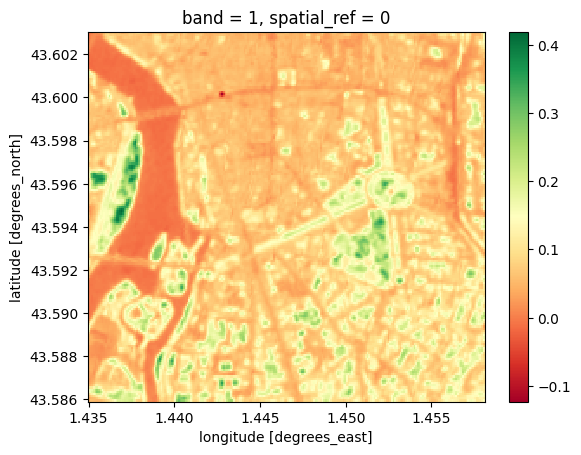

In [7]:
NDVI.plot(cmap="RdYlGn", center=False)